In [1]:
%load_ext watermark

In [2]:
%watermark -a Schmelling,Nicolas -u -d -v -p matplotlib,numpy,pandas

Schmelling,Nicolas 
Last updated: 26/11/2015 

CPython 2.7.9
IPython 3.0.0

matplotlib 1.4.3
numpy 1.9.2
pandas 0.15.2


---
Any comments and suggestions or questions?     
Please feel free to contact me via [twitter](https://twitter.com/bio_mediocre) or [email](mailto:schmelli@msu.edu).

---

#Distribution of circadian clock proteins from plants#
---

In the previous [IPython notebook](1_Plant_Clock_DataCollectionPreprocessing.ipynb) we collected all sorts of data about BLAST results and metrics, and additional information about the organism and protein itself. In the following the identity of sequence similar protein identified within the reciprocal BLAST.

---

<a id='Content'></a>
-----

#Content#
---

| [Preprocessing](#code) | [Heatmap of protein identities](#heatmap) | [Supplement Figures](#supp) |

---

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<a id='code'></a>
-----

---
###Preprocessing###
---

The input data needs to be processed prior to creating the heatmap.

1. Group the genera in the five groups according to their taxonomy. Groups are Streptophyta, Chlorophyta, Rhodophyta, Cyanobacteria, and Other. Assign a numeric identifier to each group for coloring.
2. Calculate the identity mean for each protein and genus. Create a counter of each genus to record the number of individual organisms per genus.
3. Merge the the dataframes for each protein in a single datafram containing information about protein identity for each protein and genus.

---

In [4]:
pd.set_option('mode.chained_assignment',None)

In [5]:
# The function will reduce the input dataframe down to only the taxonomy, sequence identity and organism name columns.
def simple_dataframe(name):
    
    df = pd.read_csv('%s_all.csv'%name, index_col=False)
    df = df[['query_organism','taxonomy','identity']]
    df = df.groupby(['query_organism', 'taxonomy']).mean()
    df = df.reset_index()
    df.columns = ['query_organism','taxonomy','%s_identity'%name]
    df.sort('%s_identity'%name, ascending=False, inplace=True)
    
    return df

# The function will group the genera in to four groups according to their taxonomy.
# Groups are Cyanobacteria, Proteobacteria, Archaea, and Other Bacteria. 
def categories_taxonomy(df):
    
    df.index = range(0,len(df))
    
    count = 0
    
    for i in list(df.taxonomy):
        if 'streptophyta' in str(i).lower():
            df.taxonomy[count] = 1
            count += 1
        elif 'chlorophyta' in str(i).lower():
            df.taxonomy[count] = 2
            count += 1
        elif 'rhodophyta' in str(i).lower():
            df.taxonomy[count] = 3
            count += 1
        elif 'cyanobacteria' in str(i).lower():
            df.taxonomy[count] = 4
            count += 1
        else:
            df.taxonomy[count] = 5
            count += 1
    
    return df

In [6]:
LUX = simple_dataframe('LUX')
ELF3 = simple_dataframe('ELF3')
ELF4 = simple_dataframe('ELF4')
CHE = simple_dataframe('CHE')
LHY1 = simple_dataframe('LHY1')
RVE8 = simple_dataframe('RVE8')
CCA1 = simple_dataframe('CCA1')
TOC1 = simple_dataframe('TOC1')
PRR5 = simple_dataframe('PRR5')
PRR7 = simple_dataframe('PRR7')
PRR9 = simple_dataframe('PRR9')

In [7]:
LUX = categories_taxonomy(LUX)
ELF3 = categories_taxonomy(ELF3)
ELF4 = categories_taxonomy(ELF4)
CHE = categories_taxonomy(CHE)
LHY1 = categories_taxonomy(LHY1)
RVE8 = categories_taxonomy(RVE8)
CCA1 = categories_taxonomy(CCA1)
TOC1 = categories_taxonomy(TOC1)
PRR5 = categories_taxonomy(PRR5)
PRR7 = categories_taxonomy(PRR7)
PRR9 = categories_taxonomy(PRR9)

In [8]:
# Merge the dataframes and sort by TOC1 identity
df_heat = pd.merge(LUX, ELF3, how='outer')
df_heat = pd.merge(df_heat, ELF4, how='outer')
df_heat = pd.merge(df_heat, CHE, how='outer')
df_heat = pd.merge(df_heat, LHY1, how='outer')
df_heat = pd.merge(df_heat, RVE8, how='outer')
df_heat = pd.merge(df_heat, CCA1, how='outer')
df_heat = pd.merge(df_heat, TOC1, how='outer')
df_heat = pd.merge(df_heat, PRR5, how='outer')
df_heat = pd.merge(df_heat, PRR7, how='outer')
df_heat = pd.merge(df_heat, PRR9, how='outer')

df_heat = df_heat.groupby(['query_organism', 'taxonomy']).mean()
df_heat = df_heat.reset_index()
df_heat.sort(['taxonomy','TOC1_identity'], ascending=[True,False], inplace=True)

df_heat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 42 to 620
Data columns (total 13 columns):
query_organism    622 non-null object
taxonomy          622 non-null int64
LUX_identity      16 non-null float64
ELF3_identity     54 non-null float64
ELF4_identity     40 non-null float64
CHE_identity      16 non-null float64
LHY1_identity     59 non-null float64
RVE8_identity     56 non-null float64
CCA1_identity     28 non-null float64
TOC1_identity     159 non-null float64
PRR5_identity     308 non-null float64
PRR7_identity     334 non-null float64
PRR9_identity     275 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 68.0+ KB


[Back to Content](#Content)

<a id='heatmap'></a>
-----

---
###Heatmap with sequence identities###

---

After creating the dataframes, containing the identity information to the circadian clock proteins of _Arabidopsis thaliana_, a heatmap is constructed.
A fast and actually really nice way to visualize informations from a spreadsheet is to create a [heatmap](en.wikipedia.org/wiki/Heat_map). Heatmaps are usually used to plot data, which are in a matrix format. Values are represented as colors.

I decided to use the identity rather than the e-value as values for the heatmap, b/c they vary not as much and are in a range from 0 to 100.

---

In [9]:
def heatmap(csv,name):
    
    # If you submit a dataframe
    df_h = csv
    
    f, ax = plt.subplots(1,1, figsize=(6,40))
    
    hfont = {'fontname':'Arial'}

    # Remove the plot frame lines. They are unnecessary chartjunk.  
    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)  

    # Ensure that the axis ticks only show up on the bottom and left of the plot.  
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
    ax.get_xaxis().tick_top()  
    ax.get_yaxis().tick_left()

    ax.xaxis.tick_top()

    # Put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(df_h.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(df_h.shape[1])+0.5, minor=False)
    
    # Add axis labels
    xlabels = ['LUX','ELF3','ELF4','CHE','LHY1','RVE8','CCA1','TOC1','PRR5','PRR7','PRR9']
    ax.set_xticklabels(xlabels, fontsize=17, rotation=90, **hfont)
    ylabels = list(df_h.query_organism)
    ax.set_yticklabels(ylabels, fontsize=14, **hfont)

    # Put xlabel to top of graph
    ax.xaxis.set_label_position('top')

    # Limit the range of the plot to only where the data is.  
    # Avoid unnecessary whitespace.  
    ylim(0, len(df_h.index)) 

    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="off", left="off", right="off", labelleft="on")

    # Let's do the actual ploting
    heatmap = plt.pcolor(df_h.iloc[:,2:], cmap='GnBu',vmin=0, vmax=100)

    # Modify colorbar
    cbar = plt.colorbar(fraction=.1, pad=.01, aspect=7,orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=6)
    cbar.locator = tick_locator
    cbar.update_ticks() 
    cbar.ax.set_xticklabels(np.arange(0,101,20),fontsize=14)

    cbar.outline.set_linewidth(0) 

    f.tight_layout()
    ax.invert_yaxis()

    #plt.savefig(name, format='png',dpi=500)
    plt.show()

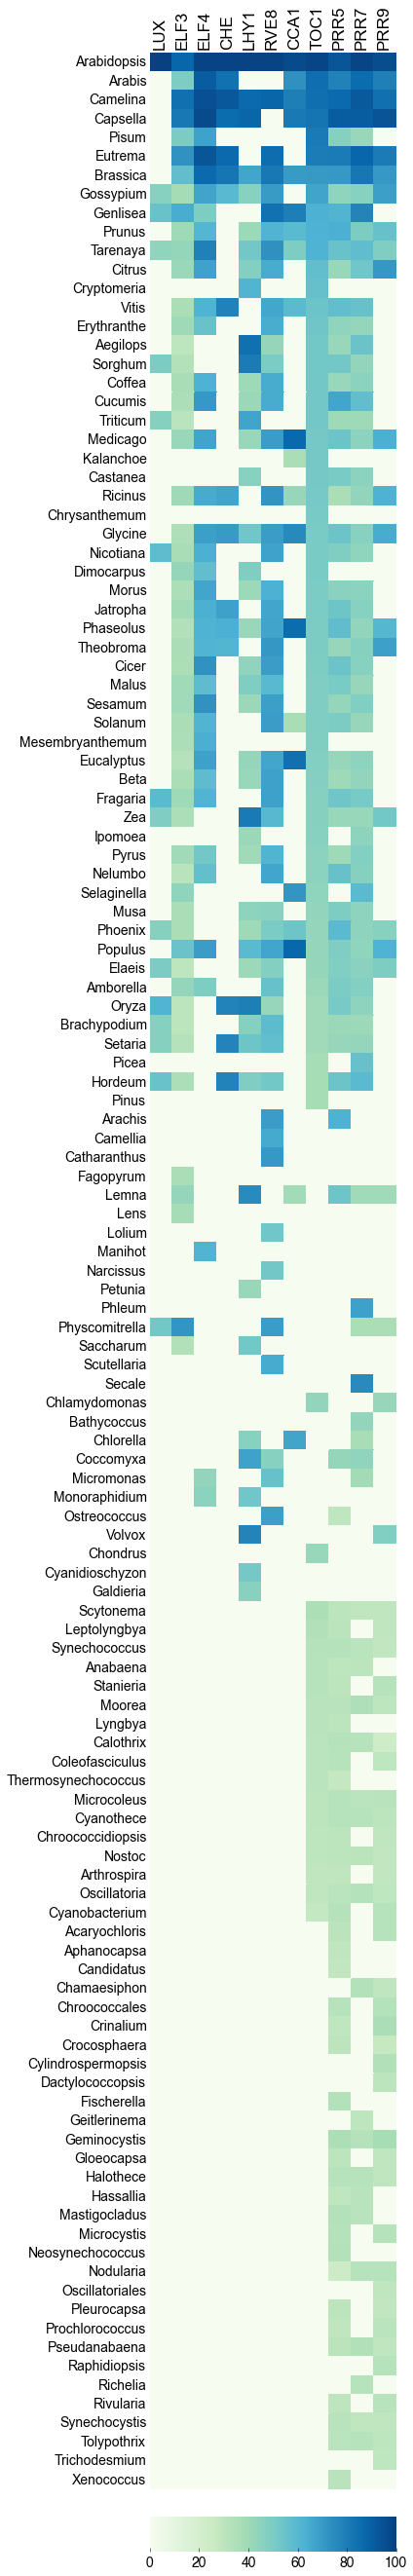

In [10]:
heatmap(df_heat[df_heat.taxonomy != 5],'plant_heatmap.png')

In [11]:
def heatmap_cyano(csv,name):
    
    # If you submit a dataframe
    df_h = csv
    
    f, ax = plt.subplots(1,1, figsize=(6,20))
    
    hfont = {'fontname':'Arial'}

    # Remove the plot frame lines. They are unnecessary chartjunk.  
    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)  

    # Ensure that the axis ticks only show up on the bottom and left of the plot.  
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
    ax.get_xaxis().tick_top()  
    ax.get_yaxis().tick_left()

    ax.xaxis.tick_top()

    # Put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(df_h.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(df_h.shape[1])+0.5, minor=False)
    
    # Add axis labels
    xlabels = ['LUX','ELF3','ELF4','CHE','LHY1','RVE8','CCA1','TOC1','PRR5','PRR7','PRR9']
    ax.set_xticklabels(xlabels, fontsize=17, rotation=90, **hfont)
    ylabels = list(df_h.query_organism)
    ax.set_yticklabels(ylabels, fontsize=16, **hfont)

    # Put xlabel to top of graph
    ax.xaxis.set_label_position('top')

    # Limit the range of the plot to only where the data is.  
    # Avoid unnecessary whitespace.  
    ylim(0, len(df_h.index)) 

    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="off", left="off", right="off", labelleft="on")

    # Let's do the actual ploting
    heatmap = plt.pcolor(df_h.iloc[:,2:], cmap='GnBu',vmin=0, vmax=100)

    # Modify colorbar
    cbar = plt.colorbar(fraction=.1, pad=.01, aspect=12, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=6)
    cbar.locator = tick_locator
    cbar.update_ticks() 
    cbar.ax.set_xticklabels(np.arange(0,101,20),fontsize=14)

    cbar.outline.set_linewidth(0) 

    f.tight_layout()
    ax.invert_yaxis()

    #plt.savefig(name, format='png',dpi=500)
    plt.show()

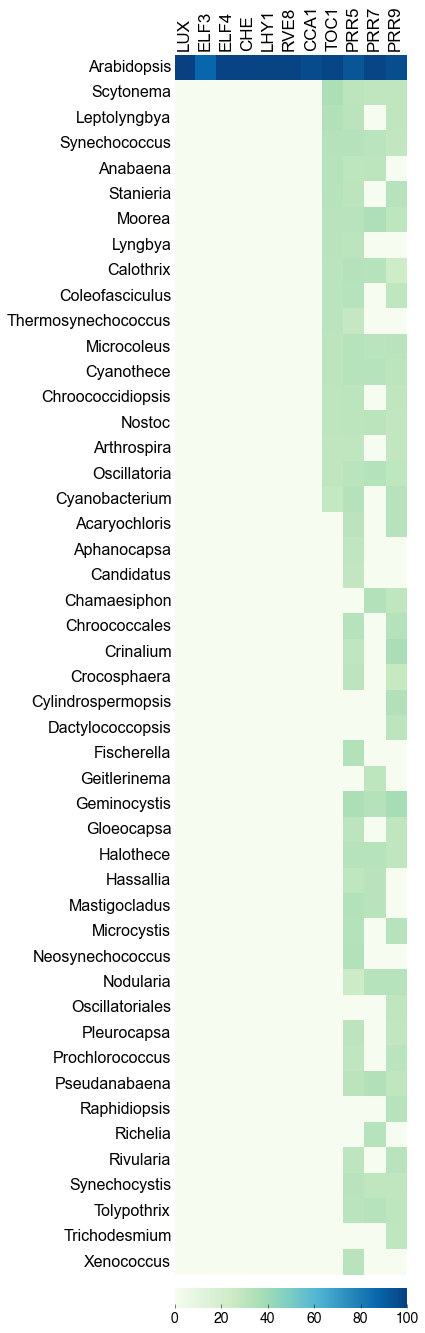

In [12]:
heatmap_cyano(df_heat[(df_heat.query_organism == 'Arabidopsis') | (df_heat.taxonomy == 4)],'Ara_cyano_heatmap.png')

[Back to Content](#Content)

<a id='supp'></a>
-----

---
###Supplement Figure###

---

In [13]:
plant = ['LUX','ELF3','ELF4','CHE','LHY1','RVE8','CCA1','TOC1','PRR5','PRR7','PRR9']

In [14]:
hits_plant = []
hits_back_plant = []
hits_filter_plant = []

for i in plant:
    df = pd.read_csv('%s_BLAST.csv'%i)
    hits_plant.append(len(df))
    df = pd.read_csv('%s_hits.csv'%i)
    hits_back_plant.append(len(df))
    df = pd.read_csv('%s_all.csv'%i)
    hits_filter_plant.append(len(df))

print hits_plant
print hits_back_plant
print hits_filter_plant

[7425, 403, 674, 1351, 2543, 2503, 2472, 10517, 24376, 27573, 21818]
[56, 271, 135, 44, 290, 239, 124, 1756, 5465, 5145, 3951]
[42, 184, 100, 29, 169, 177, 67, 846, 2364, 1986, 1505]


In [15]:
def plot_barh(hits, hits_back, filters, genes, name):

    f, ax = plt.subplots(1,1, figsize=(3.75,8.5)) 
    
    hfont = {'fontname':'Arial'}
    
    # Remove the plot frame lines. They are unnecessary chartjunk.   
    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)  

    # Ensure that the axis ticks only show up on the bottom and left of the plot.  
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
    ax.get_xaxis().tick_top()  
    ax.get_yaxis().tick_left()  

    # Add gridlines for x-axis
    ax.xaxis.grid(True, lw=2, linestyle='-', alpha=1, color='w')

    # Limit the range of the plot to only where the data is.  
    # Avoid unnecessary whitespace.  
    xlim(-100, 40500) 

    # Make sure your axis ticks are large enough to be easily read.  
    # You don't want your viewers squinting to read your plot.  
    width = 0.3
    xticks(range(0, 35001, 10000), [str(x)+'k' for x in range(0, 45, 10)], fontsize=12, rotation=0, **hfont)  
    yticks(np.arange(len(hits))+width/2, genes, fontsize=12, **hfont)

    # Put xlabel to top of graph
    ax.xaxis.set_label_position('top') 

    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.  
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="off", left="off", right="off", labelleft="on")
    
    # Let's do the actual ploting
    nr_blastp = ax.barh(np.arange(len(hits))-width, hits, width, align='center', color='darkgreen',
                       alpha=0.2, lw=0, label='nr')

    back_blastp = ax.barh(np.arange(len(hits_back)), hits_back, width, align='center', color='darkgreen',
                       alpha=0.7, lw=0, label='Genome')
    
    filter_blastp = ax.barh(np.arange(len(hits_back))+width, filters, width, align='center', color='darkgreen',
                       alpha=1, lw=0, label='Filter')

    # Add labels and legend
    plt.xlabel('No. of blast hits', fontsize=14, **hfont)
    plt.legend(loc='best', fontsize=11).draw_frame(False)


    # Add bar labels so the viewer can directly see the actual value.
    def col_label(col):
        # Attach the value to the bars
        for val in col:
            width = int(val.get_width())
            
            # Check if the value is smaller than 40000, if so show the value right of the bar in black color
            if (width < 40000):
                xloc = width + 500
                clr = 'black'
                align = 'left'
                
            # Is the value is larger than 40000, show the value inside the bar in white color
            else:
                xloc = width - 1000
                clr = 'white'
                align = 'right'
                
            ax.text(xloc, val.get_y() + val.get_height()/2., '%d'%width,
                    horizontalalignment=align, verticalalignment='center', color=clr, weight='bold',
                    fontsize=9, **hfont)

    col_label(nr_blastp)
    col_label(back_blastp)
    col_label(filter_blastp)

    f.tight_layout()
    ax.invert_yaxis()

    #plt.savefig(name, format='png',dpi=600)
    plt.show()

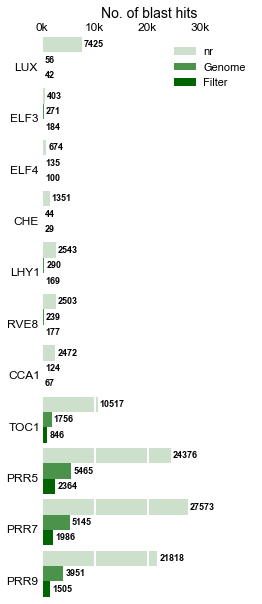

In [16]:
name = 'nr_blastp_hits_plant.png'

plot_barh(hits_plant, hits_back_plant, hits_filter_plant, plant, name)

---
###Previous###

+ [Data Collection and Processing](1_Plant_Clock_DataCollectionProcessing.ipynb)

---